# Example paralellisation dask.delayed

In [1]:
# general python
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import numpy as np
import os
from pathlib import Path
import yaml
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import scipy
import xarray as xr
from tqdm import tqdm
import glob
from devtools import pprint
from tqdm import tqdm

In [2]:
import ewatercycle.models

In [3]:
# pip uninstall ewatercycle_parallelisation_sleep -y

In [4]:
# pip install git+https://github.com/Daafip/ewatercycle-test-parallelisation@main

In [5]:
from ewatercycle.models import ParallelisationSleep

In [6]:
model = ParallelisationSleep()

In [7]:
config, _ = model.setup(sleepiness=1)

In [8]:
model.initialize(config)

In [9]:
import time

In [10]:
%%time
model.update()

CPU times: user 4.47 ms, sys: 1.57 ms, total: 6.04 ms
Wall time: 1 s


## import DA function:

In [11]:
import importlib.util

def module_from_file(module_name, file_path):
    spec = importlib.util.spec_from_file_location(module_name, file_path)
    module = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(module)
    return module

In [12]:
DA = module_from_file("DA",r'../eWaterCycle-DA/src/eWaterCycle_DA/DA.py')

In [13]:
n_particles = 3

In [14]:
ensemble = DA.Ensemble(N=n_particles)
ensemble.setup()

In [15]:
setup_kwargs= {'sleepiness':1}

In [16]:
# this initializes the models for all ensemble members. 
ensemble.initialize(model_name="ParallelisationSleep",
                    forcing=None,
                    setup_kwargs=setup_kwargs) 

## Time current update step

In [17]:
%%time
ensemble.update(assimilate=False)

CPU times: user 0 ns, sys: 12.9 ms, total: 12.9 ms
Wall time: 3.01 s


In [18]:
%%time
for ensemble_member in ensemble.ensemble_list:
    ensemble_member.update()

CPU times: user 11.9 ms, sys: 0 ns, total: 11.9 ms
Wall time: 3.01 s


## using dask

In [19]:
from dask import delayed

In [20]:
@delayed
def update_member(ensemble, i):
    ensemble.ensemble_list[i].update()
    return ensemble.ensemble_list[i].get_value("sleep")

In [21]:
@delayed
def gather(*args):
    return list(args)

In [22]:
gathered = gather(*[update_member(ensemble,i) for i in range(ensemble.N)])

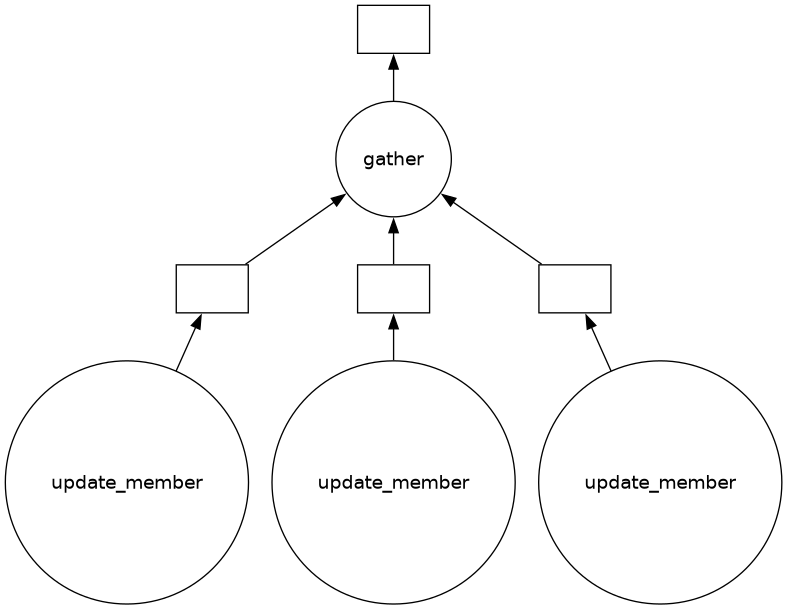

In [23]:
gathered.visualize()

In [24]:
%%time
gathered.compute()

1.01 s ± 1.26 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [25]:
ensemble.finalize()

## repeat with more particles & longer time

In [26]:
n_particles = 30

In [27]:
ensemble = DA.Ensemble(N=n_particles)
ensemble.setup()

In [28]:
setup_kwargs= {'sleepiness':1}

In [29]:
%%time
# starting up this many docker containers also is a thing but yeah:
# this initializes the models for all ensemble members. 
ensemble.initialize(model_name="ParallelisationSleep",
                    forcing=None,
                    setup_kwargs=setup_kwargs) 

## Time current update step

In [30]:
%%time
ensemble.update(assimilate=False)

CPU times: user 94.9 ms, sys: 25.8 ms, total: 121 ms
Wall time: 30.1 s


## using dask

In [31]:
gathered = gather(*[update_member(ensemble,i) for i in range(ensemble.N)])

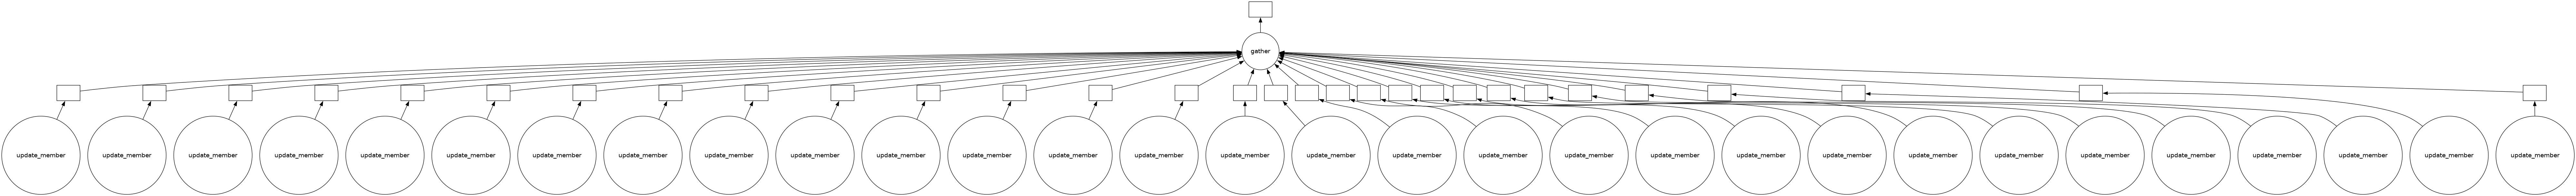

In [32]:
gathered.visualize()

In [33]:
%%time
gathered.compute()

3.02 s ± 2.62 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [34]:
ensemble.finalize()

Exluding the initialization: x10 speed up